In [7]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import os
from tensorflow.keras.applications import MobileNetV3Small
from keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow_addons as tfa
from tensorflow.keras import mixed_precision

# 데이터셋 로더

In [2]:
# **1. GPU 메모리 성장 설정 (가장 먼저 실행)**
physical_devices = tf.config.list_physical_devices('GPU')
for gpu in physical_devices:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
        print(f"메모리 성장 설정 완료: {gpu}")
    except RuntimeError as e:
        print(f"메모리 성장 설정 실패: {gpu} - {e}")

# **2. 분산 전략 설정**
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# **3. Mixed Precision 비활성화**
policy = mixed_precision.Policy('float32')
mixed_precision.set_global_policy(policy)

# **4. 데이터셋 로더 함수**
def load_data(csv_file, image_dir):
    df = pd.read_csv(csv_file)
    image_paths = df['image_path'].tolist()
    keypoints = df.iloc[:, 1:].values.astype(np.float32)
    return image_paths, keypoints

# **5. 키포인트 스케일링 함수 정의**
def scale_keypoints(keypoints, original_width=720, original_height=1280, target_size=224):
    keypoints = tf.convert_to_tensor(keypoints, dtype=tf.float32)
    x_coords = keypoints[::2]
    y_coords = keypoints[1::2]
    x_scale = target_size / original_width
    y_scale = target_size / original_height
    x_scaled = x_coords * x_scale
    y_scaled = y_coords * y_scale
    scaled_keypoints = tf.stack([x_scaled, y_scaled], axis=1)
    scaled_keypoints = tf.reshape(scaled_keypoints, [-1])
    return scaled_keypoints

# **6. 데이터 증강 함수 정의 (현재 사용 안 함)**
def augment(image, keypoints):
    # 랜덤 회전
    angle = tf.random.uniform([], -15, 15, dtype=tf.float32)
    angle_rad = angle * np.pi / 180.0
    image = tfa.image.rotate(image, angles=angle_rad, fill_mode='nearest')
    
    # 키포인트 회전
    center_x = 720.0 / 2 * (224 / 720.0)  # 224x224 이미지 기준 (720 -> 224)
    center_y = 1280.0 / 2 * (224 / 1280.0)  # 1280 -> 224
    rotation_matrix = tf.reshape([
        tf.cos(angle_rad), -tf.sin(angle_rad),
        tf.sin(angle_rad), tf.cos(angle_rad)
    ], [2, 2])
    keypoints = tf.reshape(keypoints, [NUM_KEYPOINTS, 2])
    keypoints = tf.matmul(keypoints - tf.constant([center_x, center_y]), rotation_matrix) + tf.constant([center_x, center_y])
    keypoints = tf.reshape(keypoints, [-1])
    
    return image, keypoints

# **7. 이미지 및 키포인트 전처리 함수 (종횡비 유지 및 패딩 추가)**
def preprocess_image(image_path, keypoints, image_dir, target_size=224, original_width=720, original_height=1280):
    # 이미지 경로 결합
    image_full_path = tf.strings.join([image_dir, '/', image_path])
    
    # 이미지 로드 및 디코드
    image = tf.io.read_file(image_full_path)
    image = tf.image.decode_jpeg(image, channels=3)
    
    # 이미지가 정상적으로 로드되었는지 확인하고, float32로 변환 및 [0,1] 범위로 스케일링
    image = tf.cond(tf.equal(tf.size(image), 0),
                   lambda: tf.zeros([target_size, target_size, 3], dtype=tf.float32),
                   lambda: tf.image.convert_image_dtype(image, tf.float32))
    
    # 원본 크기 가져오기
    orig_shape = tf.shape(image)[:2]
    orig_height_img = tf.cast(orig_shape[0], tf.float32)
    orig_width_img = tf.cast(orig_shape[1], tf.float32)
    
    # 종횡비 유지하며 리사이징
    scale = tf.minimum(target_size / orig_width_img, target_size / orig_height_img)
    new_width = tf.cast(tf.round(orig_width_img * scale), tf.int32)
    new_height = tf.cast(tf.round(orig_height_img * scale), tf.int32)
    
    image = tf.image.resize(image, [new_height, new_width])
    
    # 패딩 추가하여 타겟 사이즈 맞추기
    pad_width = target_size - new_width
    pad_height = target_size - new_height
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top
    
    image = tf.pad(image, [[pad_top, pad_bottom], [pad_left, pad_right], [0, 0]], constant_values=0)
    
    # 키포인트 스케일 조정 및 이동 후 정규화
    keypoints = tf.convert_to_tensor(keypoints, dtype=tf.float32)
    x_coords = keypoints[::2]
    y_coords = keypoints[1::2]
    
    # 스케일링 및 이동
    x_scale = scale
    y_scale = scale
    
    x_scaled = x_coords * x_scale + tf.cast(pad_left, tf.float32)
    y_scaled = y_coords * y_scale + tf.cast(pad_top, tf.float32)
    
    # 정규화
    x_normalized = x_scaled / target_size
    y_normalized = y_scaled / target_size
    
    scaled_keypoints = tf.stack([x_normalized, y_normalized], axis=1)
    scaled_keypoints = tf.reshape(scaled_keypoints, [-1])
    
    return image, scaled_keypoints

# **8. 데이터셋 전처리 및 증강 함수**
def preprocess_image_aug(image_path, keypoints, image_dir, target_size=224, original_width=720, original_height=1280):
    image, keypoints = preprocess_image(image_path, keypoints, image_dir, target_size, original_width, original_height)
    image, keypoints = augment(image, keypoints)
    return image, keypoints

# **9. 데이터셋 생성 함수 수정**
def create_dataset(image_paths, keypoints, image_dir, batch_size=64, shuffle=True, augment_data=False, target_size=224, original_width=720, original_height=1280):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, keypoints))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_paths))
    
    # image_dir을 TensorFlow 상수로 변환
    image_dir_tf = tf.constant(image_dir)
    
    if augment_data:
        # 데이터 증강 적용
        dataset = dataset.map(lambda x, y: preprocess_image_aug(x, y, image_dir_tf, target_size, original_width, original_height), num_parallel_calls=tf.data.AUTOTUNE)
    else:
        # 데이터 증강 미적용
        dataset = dataset.map(lambda x, y: preprocess_image(x, y, image_dir_tf, target_size, original_width, original_height), num_parallel_calls=tf.data.AUTOTUNE)
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

메모리 성장 설정 완료: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
메모리 성장 설정 완료: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
메모리 성장 설정 완료: PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')
Number of devices: 3


2024-11-04 07:35:39.540313: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-04 07:35:39.542469: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-04 07:35:39.544482: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
# CSV 파일 경로
train_csv = 'keras_dataset/annotations/train_annotations.csv'
val_csv = 'keras_dataset/annotations/val_annotations.csv'

# 이미지 디렉토리
train_image_dir = 'keras_dataset/images/train'
val_image_dir = 'keras_dataset/images/val'

# 로드된 데이터
train_image_paths, train_keypoints = load_data(train_csv, train_image_dir)
val_image_paths, val_keypoints = load_data(val_csv, val_image_dir)

# 전체 배치 크기 설정
BATCH_SIZE_PER_REPLICA = 16  # 각 GPU당 배치 크기 (메모리 문제를 방지하기 위해 줄임)
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync  # 전체 배치 크기

# 훈련 및 검증 데이터셋 생성
train_dataset = create_dataset(
    train_image_paths, 
    train_keypoints, 
    train_image_dir, 
    batch_size=GLOBAL_BATCH_SIZE, 
    shuffle=True, 
    augment_data=False,  # 현재 데이터 증강 비활성화
    target_size=224, 
    original_width=720, 
    original_height=1280
)

val_dataset = create_dataset(
    val_image_paths, 
    val_keypoints, 
    val_image_dir, 
    batch_size=GLOBAL_BATCH_SIZE, 
    shuffle=False, 
    augment_data=False, 
    target_size=224, 
    original_width=720, 
    original_height=1280
)

# 키포인트 시각화

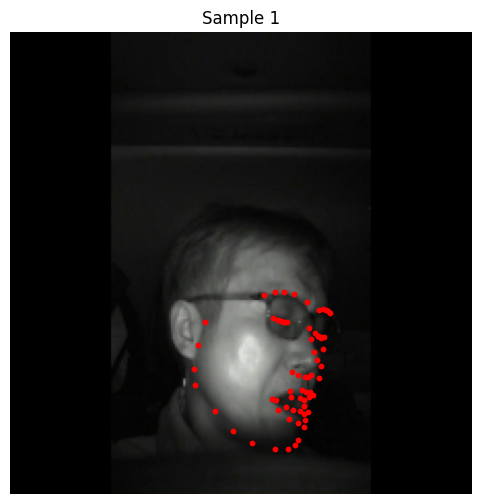

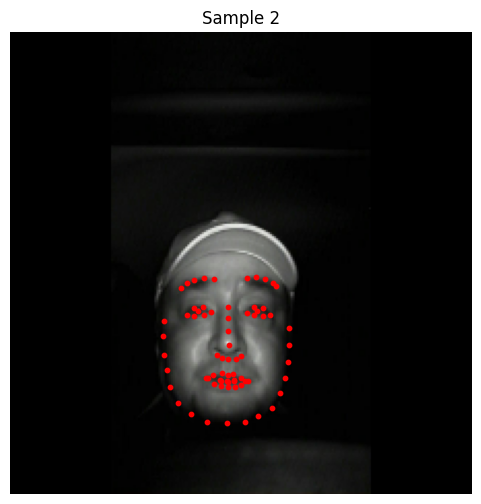

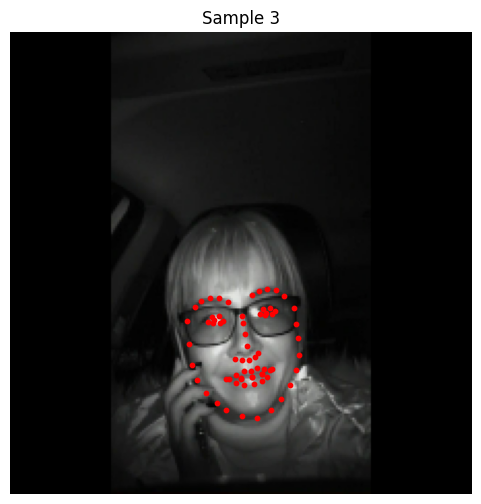

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 데이터셋 일부 시각화 (디버깅 용도)
def visualize_sample(image, keypoints, title='Sample', image_size=224):
    image_np = image.numpy()
    plt.figure(figsize=(6, 6))
    plt.imshow(image_np)
    # 키포인트를 224x224 이미지에 맞게 스케일링
    x = keypoints[::2].numpy() * image_size  # [0,1] 범위를 [0,224]로 변환
    y = keypoints[1::2].numpy() * image_size
    plt.scatter(x, y, c='r', s=10)
    plt.title(title)
    plt.axis('off')
    plt.show()

# 데이터셋에서 샘플 가져오기
for images, keypoints in train_dataset.take(1):
    for i in range(3):  # 첫 3개 샘플 시각화
        visualize_sample(images[i], keypoints[i], title=f"Sample {i+1}")

In [5]:
print("키포인트 최소값:", tf.reduce_min(keypoints))
print("키포인트 최대값:", tf.reduce_max(keypoints))
print("이미지 크기:", images[0].shape)

키포인트 최소값: tf.Tensor(0.28637812, shape=(), dtype=float32)
키포인트 최대값: tf.Tensor(0.9008289, shape=(), dtype=float32)
이미지 크기: (224, 224, 3)


# 모델학습

In [8]:
import keras
from keras import layers

# 키포인트 수
NUM_KEYPOINTS = 70

# 전략 범위 내에서 모델 정의 및 컴파일
with strategy.scope():
    # 입력 레이어 정의
    inputs = layers.Input(shape=(224, 224, 3))
    x = preprocess_input(inputs)

    # 백본 모델 로드 (pre-trained MobileNetV3Large)
    base_model = MobileNetV3Small(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = True  # 백본 모델을 학습하도록 설정

    x = base_model(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)

    # 출력 레이어: 70개의 키포인트, 각 키포인트에 대해 x, y 좌표 (총 140개 출력)
    # 타겟 값이 [0, 1] 범위로 정규화되었다면 sigmoid 활성화 함수 사용
    x = layers.Dense(NUM_KEYPOINTS * 2, activation='sigmoid', dtype='float32')(x)

    # 모델 정의
    model = keras.Model(inputs=inputs, outputs=x)

    # 모델 컴파일
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# 모델 요약 출력
model.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [8]:
len(base_model.layers)

229

In [9]:
from tensorflow.keras.callbacks import Callback, LearningRateScheduler
import time

def lr_scheduler(epoch):
    if epoch < 50:
        return 0.001  # 첫 50 에포크 동안 학습률은 0.001
    else:
        return 0.0001  # 에포크 51부터 100까지 학습률은 0.0005

# 에포크 시간 측정을 위한 콜백 클래스 정의
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()
        
# 콜백 설정
checkpoint = ModelCheckpoint('v3s_adam_lr.h5', monitor='val_loss', save_best_only=True, verbose=1)
lr_scheduler_callback = LearningRateScheduler(lr_scheduler)
time_callback = TimeHistory()
# early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

# 모델 훈련
EPOCHS = 100

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[checkpoint, lr_scheduler_callback, time_callback]
)

Epoch 1/100
INFO:tensorflow:Collective all_reduce tensors: 140 all_reduces, num_devices = 3, group_size = 3, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 140 all_reduces, num_devices = 3, group_size = 3, implementation = CommunicationImplementation.NCCL, num_packs = 1


2024-11-04 07:39:52.233028: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-11-04 07:39:52.268208: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-11-04 07:39:52.294960: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-11-04 07:39:56.470275: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f346e01eac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-04 07:39:56.470318: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-11-04 07:39:56.470325: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-11-04 07:39:56.470330: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): Tesla T4, Compute Capability 7.5
2024-11-04 07:39:56.479887: I ten

856/856 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.0220
Epoch 1: val_loss improved from inf to 0.02102, saving model to v3s_adam_lr.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


856/856 [==============================] - 166s 125ms/step - loss: 0.0011 - mae: 0.0220 - val_loss: 0.0210 - val_mae: 0.1192 - lr: 0.0010
Epoch 2/100
856/856 [==============================] - ETA: 0s - loss: 2.4994e-04 - mae: 0.0121
Epoch 2: val_loss did not improve from 0.02102
856/856 [==============================] - 101s 117ms/step - loss: 2.4994e-04 - mae: 0.0121 - val_loss: 0.0507 - val_mae: 0.1844 - lr: 0.0010
Epoch 3/100
856/856 [==============================] - ETA: 0s - loss: 1.6890e-04 - mae: 0.0099
Epoch 3: val_loss did not improve from 0.02102
856/856 [==============================] - 101s 118ms/step - loss: 1.6890e-04 - mae: 0.0099 - val_loss: 0.0397 - val_mae: 0.1756 - lr: 0.0010
Epoch 4/100
856/856 [==============================] - ETA: 0s - loss: 1.3441e-04 - mae: 0.0088
Epoch 4: val_loss did not improve from 0.02102
856/856 [==============================] - 100s 116ms/step - loss: 1.3441e-04 - mae: 0.0088 - val_loss: 0.0307 - val_mae: 0.1461 - lr: 0.0010
Epoch 5

In [10]:
# 평균 에포크 시간 계산 및 출력
average_epoch_time = np.mean(time_callback.times)
print(f"에포크당 평균 소요 시간: {average_epoch_time:.2f}초")

에포크당 평균 소요 시간: 104.49초


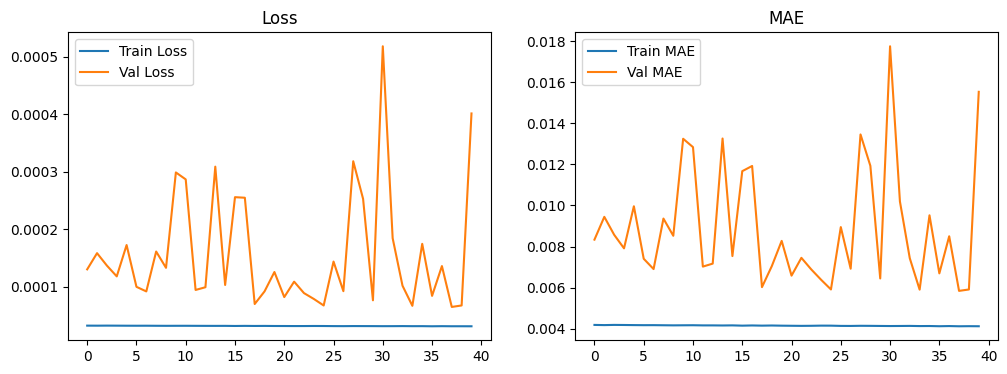

In [20]:
import matplotlib.pyplot as plt

# 훈련 손실 및 MAE 시각화
plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'][60:], label='Train Loss')
plt.plot(history.history['val_loss'][60:], label='Val Loss')
plt.legend()
plt.title('Loss')

# MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'][60:], label='Train MAE')
plt.plot(history.history['val_mae'][60:], label='Val MAE')
plt.legend()
plt.title('MAE')

plt.show()

In [12]:
b_m = tf.keras.models.load_model('v3s_adam_lr.h5')

1/1 [==============================] - 2s 2s/step


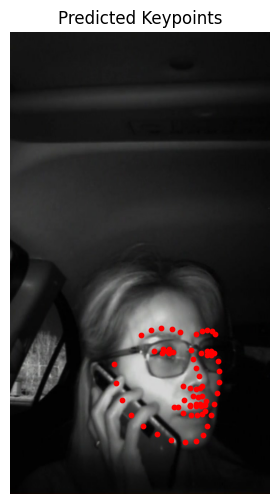

In [13]:
def plot_predicted_keypoints(model, image_path, image_dir, target_size=224):
    """
    모델을 사용하여 이미지의 키포인트를 예측하고 시각화하는 함수.

    Parameters:
        model (tf.keras.Model): 사전 학습된 모델.
        image_path (str): 예측할 이미지의 경로.
        image_dir (str): 이미지가 저장된 디렉토리 경로.
        target_size (int): 모델의 입력 이미지 크기.
    """
    # 이미지 로드 및 전처리
    image_full_path = os.path.join(image_dir, image_path)
    image = cv2.imread(image_full_path)
    if image is None:
        print(f"이미지를 불러올 수 없습니다: {image_full_path}")
        return
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    orig_h, orig_w = image_rgb.shape[:2]

    # 이미지 전처리 (학습 시 사용한 방식과 동일하게)
    # 종횡비 유지하며 리사이즈
    scale = min(target_size / orig_w, target_size / orig_h)
    new_w = int(orig_w * scale)
    new_h = int(orig_h * scale)
    image_resized = cv2.resize(image_rgb, (new_w, new_h))

    # 패딩 추가하여 타겟 사이즈 맞추기
    pad_w = target_size - new_w
    pad_h = target_size - new_h
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left
    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top

    image_padded = cv2.copyMakeBorder(
        image_resized, pad_top, pad_bottom, pad_left, pad_right,
        cv2.BORDER_CONSTANT, value=0
    )

    # 이미지 흑백 변환 및 3채널로 확장 (모델 학습 시에 흑백 이미지를 사용한 경우)
    image_gray = cv2.cvtColor(image_padded, cv2.COLOR_RGB2GRAY)
    image_input = cv2.cvtColor(image_gray, cv2.COLOR_GRAY2RGB)

    # 정규화 및 배치 차원 추가
    input_image = image_input / 255.0
    input_image = np.expand_dims(input_image, axis=0).astype(np.float32)

    # 예측
    predicted_keypoints = model.predict(input_image)[0]

    # 모델 출력이 [0,1] 범위이므로, 이를 [0, target_size]로 변환
    predicted_keypoints = predicted_keypoints * target_size

    # 패딩 제거 및 원본 이미지 크기로 복원
    predicted_keypoints[::2] = (predicted_keypoints[::2] - pad_left) / scale
    predicted_keypoints[1::2] = (predicted_keypoints[1::2] - pad_top) / scale

    # 시각화
    plt.figure(figsize=(10, 6))
    plt.imshow(image_rgb)

    num_keypoints = len(predicted_keypoints) // 2

    for i in range(num_keypoints):
        x = predicted_keypoints[2 * i]
        y = predicted_keypoints[2 * i + 1]
        # 키포인트가 이미지 범위 내에 있는지 확인
        if 0 <= x < orig_w and 0 <= y < orig_h:
            plt.scatter(x, y, c='r', s=10)
        else:
            print(f"키포인트 {i}가 이미지 범위를 벗어났습니다: ({x}, {y})")

    plt.title('Predicted Keypoints')
    plt.axis('off')
    plt.show()

# 예측 및 시각화
sample_image_path = val_image_paths[50]
plot_predicted_keypoints(b_m, sample_image_path, val_image_dir)